In [ ]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader # Changed Dataloader to DataLoader
from torchsummary import summary


from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings('ignore')

In [ ]:
###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()




In [ ]:
 # Global Variables

RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

NOISE = 0.2
EPOCHS = 2001
ALPHA = 0.001
BATCH_SIZE = 256
TEST_SIZE = 3811 #18147 - 56*256

# set the plotting parameters
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')



**LOAD DATA**

In [ ]:
data_df = pd.read_csv('fifa_2019.csv')

In [ ]:
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [ ]:
data_df.isnull().sum()

,0
Unnamed: 0,0
ID,0
Name,0
Age,0
Photo,0
...,...
GKHandling,48
GKKicking,48
GKPositioning,48
GKReflexes,48


In [ ]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [ ]:
data_df= data_df[data_df['Position'].notnull()]
data_df.head()


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [ ]:
for col in data_df.columns:
  unq = data_df[col].unique()
  print(f'{col}: {len(unq)}, Values: {unq}')


Unnamed: 0: 18147, Values: [    0     1     2 ... 18204 18205 18206]
ID: 18147, Values: [158023  20801 190871 ... 241638 246268 246269]
Name: 17140, Values: ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age: 29, Values: [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo: 18147, Values: ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality: 164, Values: ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece'

In [ ]:
data_df['Position'].isnull().sum()

0

In [ ]:
data_df['Positioning'].value_counts()

,count
Positioning,
58.0,574
65.0,537
62.0,516
64.0,509
60.0,503
...,...
90.0,4
91.0,3
93.0,2


In [ ]:
#Following columns appear to be relevant for our analysis

rel_cols= ['Position','Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [ ]:
data_df.isna().sum().sum()

0

In [ ]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [ ]:
data_df['Position'].nunique()

27

In [ ]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']
midfielder = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [ ]:
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0
data_df.loc[data_df['Position'].isin(defender), 'Position'] = 1
data_df.loc[data_df['Position'].isin(midfielder), 'Position'] = 2
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast= 'integer')

In [ ]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [ ]:
class_labels = {0: 'Goalkeeper', 1: 'Defender', 2: 'Midfielder', 3: 'Forward'}

In [ ]:
X = features_df = data_df.drop('Position', axis = 1)
y = target_df = data_df['Position'].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((14336, 33), (3811, 33), (14336,), (3811,))

In [ ]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

Is Environment Ok

In [ ]:
torch.cuda.is_available()

False

In [ ]:
torch.version.cuda

'12.1'

In [ ]:
#torch.cuda.get_device_name(torch.cuda.current_device())

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
input_dim= X_train.shape[1]

class Model(nn.Module):
  def __init__(self, input_dim):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(input_dim,18)
    self.actv1 = nn.ReLU() # Remove the trailing comma here
    self.layer2= nn.Linear(18,4)

  def forward(self, x):
    x = self.layer1(x)
    x = self.actv1(x)
    x = self.layer2(x)
    return x

model = Model (input_dim).to(device)



print(model)

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (actv1): ReLU()
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [66]:
summary(model,(1,33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 18]             612
              ReLU-2                [-1, 1, 18]               0
            Linear-3                 [-1, 1, 4]              76
Total params: 688
Trainable params: 688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
for param in list(model.parameters()):
  print(param.shape)

torch.Size([18, 33])
torch.Size([18])
torch.Size([4, 18])
torch.Size([4])


In [72]:
#Convert Features
train_X = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.int64)

test_X = torch.tensor(X_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.int64)

In [84]:
#Training Steps on  Train
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
# some lists to collect progress
loss = []
tloss=[]
n_epoch =[]
acc= []
tacc= []

#loop for defined epochs
for epoch in range(EPOCHS):
    model.train()  #set your model in train mode
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0


    for batch_idx, (train_X, train_y) in enumerate(train_loader):
      train_X= train_X.to(device)
      train_y= train_y.to(device)
      predict_proba = model(train_X) #make predictions
      batch_loss= loss_fn(predict_proba, train_y) #calculate loss
      epoch_loss +=(batch_loss -epoch_loss)/(batch_idx+1) #Calculate running mean

      # Backpropagation
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      y_pred = predict_proba.argmax(dim=1).cpu().numpy()
      batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
      epoch_acc +=(batch_acc -epoch_acc)/(batch_idx+1)

    # loss.append(batch_loss.data.item())

    # y_pred = torch.argmax(predict_proba, dim=1).cpu().numpy()

    # curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
    # acc.append(epoch_acc)

    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    model.eval() # set your model in eval mode

    for batch_idx,(test_X, test_y) in enumerate(test_loader):
      test_X, test_y = test_X.to(device), test_y.to(device)
      test_proba = model(test_X) # make prediction
      batch_loss = loss_fn(test_proba, test_y)  #calculate loss
      tepoch_loss +=(batch_loss -tepoch_loss)/(batch_idx+1) #Calculate running mean
      y_pred= test_proba.argmax(dim=1).cpu().numpy()
      batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
      tepoch_acc +=(batch_acc -tepoch_acc)/(batch_idx+1)

    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.item()) # This is the line that caused the error, it was calling .data() which returns a tensor which can't have .item() called
    n_epoch.append(epoch)


    if epoch % 10 == 0:
     print(f'Epoch: {epoch:>5d} | Loss:{epoch_loss:.5f}/{tepoch_loss:.5f}) | Acc:{epoch_acc:.5f}/{tepoch_acc:.5f}')

Epoch:     0 | Loss:0.25546/0.25552) | Acc:0.89614/0.89586
Epoch:    10 | Loss:0.25499/0.25414) | Acc:0.89558/0.89628
Epoch:    20 | Loss:0.25439/0.25403) | Acc:0.89628/0.89718
Epoch:    30 | Loss:0.25435/0.25359) | Acc:0.89614/0.89739
Epoch:    40 | Loss:0.25417/0.25317) | Acc:0.89579/0.89788
Epoch:    50 | Loss:0.25383/0.25269) | Acc:0.89676/0.89593
Epoch:    60 | Loss:0.25370/0.25439) | Acc:0.89690/0.89558
Epoch:    70 | Loss:0.25389/0.25207) | Acc:0.89746/0.89704
Epoch:    80 | Loss:0.25314/0.25227) | Acc:0.89704/0.89648
Epoch:    90 | Loss:0.25349/0.25221) | Acc:0.89600/0.89725
Epoch:   100 | Loss:0.25308/0.25188) | Acc:0.89662/0.89816
Epoch:   110 | Loss:0.25272/0.25136) | Acc:0.89697/0.89760
Epoch:   120 | Loss:0.25229/0.25157) | Acc:0.89662/0.89718
Epoch:   130 | Loss:0.25216/0.25127) | Acc:0.89739/0.89795
Epoch:   140 | Loss:0.25236/0.25060) | Acc:0.89725/0.89760
Epoch:   150 | Loss:0.25193/0.25080) | Acc:0.89662/0.89851
Epoch:   160 | Loss:0.25159/0.25040) | Acc:0.89697/0.898

In [85]:
tacc

[0.8958565848214287,
 0.8961356026785717,
 0.8966238839285714,
 0.89599609375,
 0.8964146205357144,
 0.8967633928571427,
 0.8966238839285716,
 0.8964146205357144,
 0.8971121651785714,
 0.8966936383928568,
 0.896275111607143,
 0.8960658482142857,
 0.896065848214286,
 0.8964843749999999,
 0.89599609375,
 0.8972516741071428,
 0.8971819196428572,
 0.8968331473214286,
 0.8959960937500003,
 0.8972516741071429,
 0.8971819196428572,
 0.8961356026785712,
 0.897739955357143,
 0.8976004464285716,
 0.8974609375000002,
 0.8968331473214284,
 0.8972516741071427,
 0.8954380580357141,
 0.8955078124999999,
 0.8975306919642857,
 0.8973911830357143,
 0.8969029017857145,
 0.8962053571428572,
 0.8961356026785714,
 0.8972516741071432,
 0.8961356026785713,
 0.8959263392857141,
 0.8969029017857145,
 0.8972516741071426,
 0.8973911830357144,
 0.8978794642857141,
 0.8966238839285714,
 0.8959960937499999,
 0.8964146205357144,
 0.8977399553571429,
 0.8971121651785715,
 0.896484375,
 0.8973911830357145,
 0.896344866

In [86]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss': loss,
                        'test_loss': tloss,
                        'acc': acc,
                        'test_acc': tacc})

loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.255456,0.255518,0.896136,0.895857
1,1,0.255528,0.253842,0.895647,0.896136
2,2,0.255055,0.253548,0.895926,0.896624
3,3,0.256370,0.253926,0.895089,0.895996
4,4,0.255100,0.254881,0.895857,0.896415


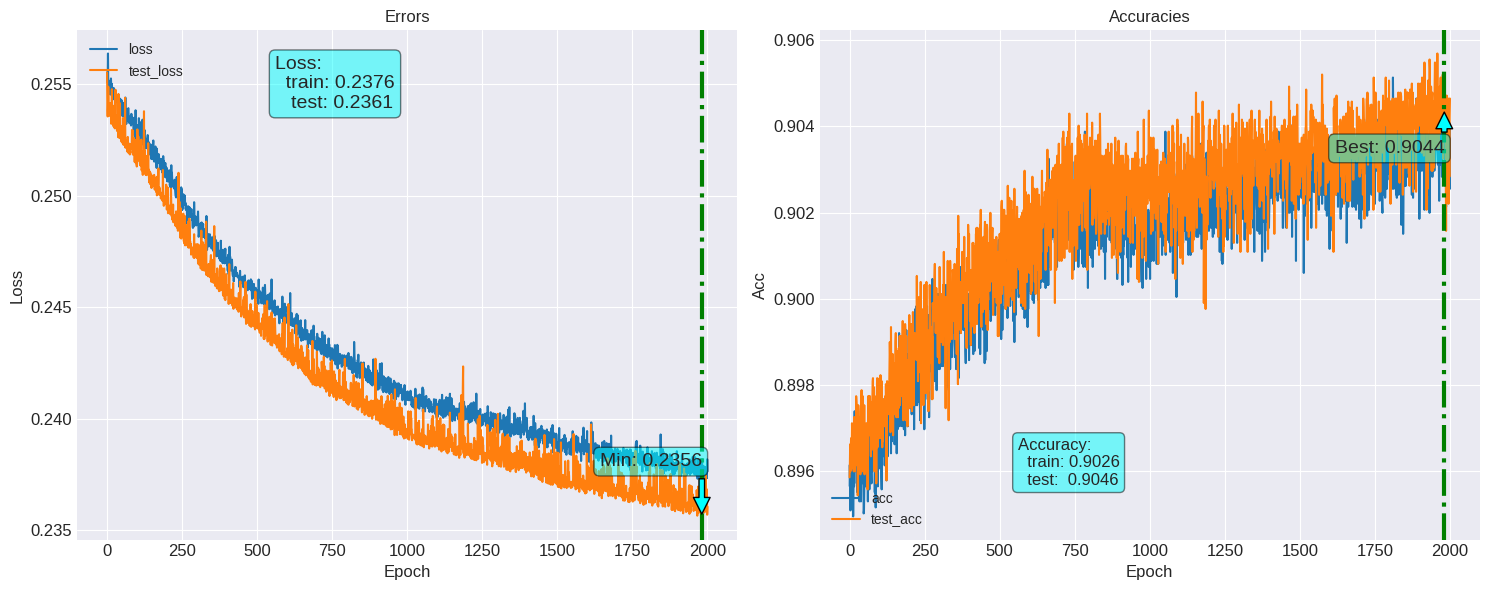

In [87]:
fn_plot_torch_hist(loss_df)

In [88]:
   outputs = model(train_X)
outputs

tensor([[ -45.1801,    2.8821,    2.4922,   -7.0389],
        [ -69.6974,    7.2861,   -3.7930,  -13.2476],
        [ -47.8313,   -1.0403,    3.1612,   -8.4456],
        ...,
        [ -91.1841,  -11.7290,    1.3950,    8.1291],
        [-111.7983,  -12.8842,    2.2366,    9.2469],
        [ -97.4211,  -13.9535,    1.9901,    9.0090]],
       grad_fn=<AddmmBackward0>)

In [89]:
outputs = model(train_X)
outputs.shape    #Tensor

torch.Size([256, 4])

In [90]:
outputs = model(train_X)    #same as above because device was not showing device='cuda:0'
outputs.cpu()               #here we are converting it to cpu

tensor([[ -45.1801,    2.8821,    2.4922,   -7.0389],
        [ -69.6974,    7.2861,   -3.7930,  -13.2476],
        [ -47.8313,   -1.0403,    3.1612,   -8.4456],
        ...,
        [ -91.1841,  -11.7290,    1.3950,    8.1291],
        [-111.7983,  -12.8842,    2.2366,    9.2469],
        [ -97.4211,  -13.9535,    1.9901,    9.0090]],
       grad_fn=<AddmmBackward0>)

In [91]:
outputs = model(train_X)    #same as above because device was not showing in the output
outputs.cpu().detach().numpy()  #.cpu() is not required

array([[ -45.180084 ,    2.8821332,    2.492208 ,   -7.038943 ],
       [ -69.697426 ,    7.286141 ,   -3.792955 ,  -13.247602 ],
       [ -47.83127  ,   -1.0403218,    3.1612163,   -8.445625 ],
       ...,
       [ -91.18414  ,  -11.729001 ,    1.3950225,    8.129057 ],
       [-111.79827  ,  -12.8842   ,    2.2366204,    9.246872 ],
       [ -97.42111  ,  -13.953539 ,    1.9900833,    9.008963 ]],
      dtype=float32)

In [92]:
outputs = model(train_X)
y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_pred

array([1, 1, 2, 3, 3, 2, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 0, 1, 3,
       2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 0, 0, 3, 1, 1, 0, 2, 3, 2, 2,
       1, 2, 0, 2, 0, 2, 2, 3, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 0, 2, 0, 3, 1, 0, 3, 2, 3, 0, 1, 1,
       3, 2, 3, 3, 2, 0, 1, 3, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2,
       3, 1, 1, 2, 1, 1, 1, 1, 1, 0, 3, 2, 0, 2, 1, 3, 0, 3, 1, 2, 1, 2,
       2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 1, 1, 2, 1, 3, 2, 1, 0,
       2, 1, 0, 1, 1, 0, 2, 3, 0, 2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 1, 0,
       2, 1, 0, 0, 3, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 3, 2, 2, 2, 1, 3, 1,
       1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 0, 3, 2, 2, 1, 1, 2, 2,
       1, 0, 2, 3, 3, 2, 2, 2, 0, 3, 2, 3, 3, 3])

In [93]:
y_train

array([1, 2, 1, ..., 0, 0, 0], dtype=int8)

In [94]:
print(classification_report(train_y.cpu().numpy(), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.98      0.98      0.98        85
           2       0.89      0.97      0.93        94
           3       0.97      0.79      0.87        43

    accuracy                           0.95       256
   macro avg       0.96      0.93      0.94       256
weighted avg       0.95      0.95      0.94       256



In [95]:
y_true = train_y.cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.98      0.98      0.98        85
           2       0.89      0.97      0.93        94
           3       0.97      0.79      0.87        43

    accuracy                           0.95       256
   macro avg       0.96      0.93      0.94       256
weighted avg       0.95      0.95      0.94       256



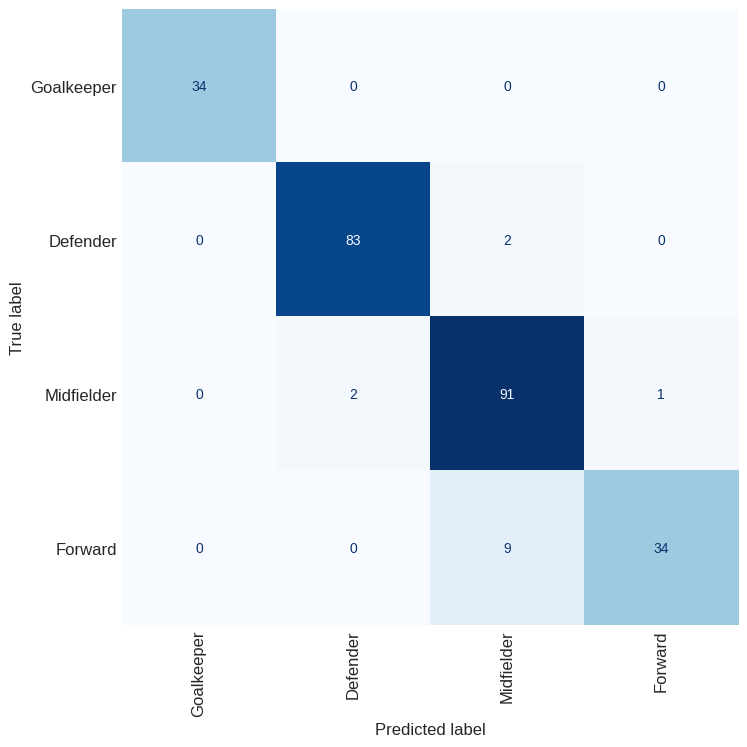

In [96]:
cm= confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels.values())
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
plt.grid(False)
plt.show()



In [ ]:
''' Define custom dataset'''
class FifaDataset(Dataset):
  def __init__(self, X, y):
    super(FifaDataset,self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
  def __len__(self):
    return(len(self.X))
  def __getitem__(self, idx):
    return(self.X[idx], self.y[idx])

In [63]:
train_dataset = FifaDataset(X_train, y_train)

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape


(torch.Size([256, 33]), torch.Size([256]))

In [64]:
test_dataset = FifaDataset(X_train, y_train)

test_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape


(torch.Size([256, 33]), torch.Size([256]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 18]             612
              ReLU-2                [-1, 1, 18]               0
            Linear-3                 [-1, 1, 4]              76
Total params: 688
Trainable params: 688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
